# Baseline Sentiment Analysis Experiment
## Model: FinBERT PT-BR
- Hypothesis: Sentiment outputs, mapped to direction, can predict short-term exchange rate movements.
- Objective: A baseline comparison before testing hyped-up LLMs capabilities
- Why DL: 
    - FinBERT is widely cited in financial NLP literature
    - outperforms general BERT and lexicon-based models on tasks like financial sentiment classification
    - Traditional ML methods rely on sparse inputs or static word embeddings (like Word2Vec) which don't capture context
    - it was used as a benchmark in very similar paper found at https://doi.org/10.1016/j.mlwa.2023.100508

- Independent Variable (Predictor):
    - Text: headline / article content
    - Category: FinBERT sentiment output
    - Binary Label: heuristic mapping (positive -> 1, negative -> -1) (bullish or bearish in commercial terms)
    - (POSSIBLY CONSIDER as a control var/experiment?): Multi-class Label: neutral (0) label defined by threshold label (min exchange rate % change)

- Dependent Variable (Ground Truth):
    - Directional Movement: binary direction of exchange rate following news timestamp (time frame TBD)
    - (POSSIBLY CONSIDER?): percent change in exchange rate over defined window? Measures profitability...

### Preprocessing

Bom Dia Mercado (BDM) → xlsx file with BDM articles and more → preprocessing to CSV → export to repository → final dataset

In [11]:
import pandas as pd
from dateutil import parser

# Step 0: Load the dataset
df = pd.read_excel("../data/raw/bdm-corpus-2.xlsx")

# Step 1–3: Normalize individual DATE and TIME cells
def parse_datetime_components(date_cell, time_cell):
    try:
        # Coerce both to string and strip spaces
        date_str = str(date_cell).strip()
        time_str = str(time_cell).strip()
        
        # Combine and parse flexibly
        dt = parser.parse(f"{date_str} {time_str}", dayfirst=True)
        return dt.isoformat()
    except Exception:
        return pd.NaT  # mark invalid rows

# Step 4: Create ISO 8601 Timestamp column
df['Timestamp'] = df.apply(lambda row: parse_datetime_components(row['DATE'], row['TIME']), axis=1)

# Step 5: Drop old columns
df.drop(columns=['DATE', 'TIME', 'Index', 'DIRECTION', 'BRER', 'LABEL'], inplace=True)

# Step 6: Clean newlines in ARTICLE CONTENT and COMMENTS
for col in ['HEADING', 'ARTICLE CONTENT', 'COMMENTS']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[\r\n]+', ' ', regex=True).str.strip()

# Step 7: Reorder columns
df = df[['Timestamp'] + [col for col in df.columns if col != 'Timestamp']]

# Step 8: Save as CSV
df.to_csv("../data/interim/bdm-corpus-2.csv", index=False, encoding='utf-8-sig')

# Step 9: Check for invalid rows (passed)
invalid_rows = df[df['Timestamp'].isna()]
print(f"{len(invalid_rows)} invalid rows found.")
print(invalid_rows)


0 invalid rows found.
Empty DataFrame
Columns: [Timestamp, HEADING, ARTICLE CONTENT, COMMENTS]
Index: []


Bloomberg → Download USD/BRL exchange rates as excel file → preprocess to CSV → export to repository → final dataset

In [ ]:
import pandas as pd
from dateutil import parser

# Step 0: Load the dataset
df = pd.read_excel("../data/raw/usd-brl.xlsx")

# Step 1: Clean column names
df.columns = [col.strip() for col in df.columns]
df.rename(columns={"Date": "Raw Timestamp", "Último preço": "USD/BRL"}, inplace=True)

# Step 2: Parse "Raw Timestamp" into ISO 8601 format
def parse_iso8601(raw):
    try:
        return parser.parse(str(raw).strip()).isoformat()
    except Exception:
        return pd.NaT

df["Timestamp"] = df["Raw Timestamp"].apply(parse_iso8601)

# Step 3: Drop the original column
df.drop(columns=["Raw Timestamp"], inplace=True)

# Step 4: Reorder columns
df = df[["Timestamp", "USD/BRL"]]

# Step 5: Save to CSV
df.to_csv("../data/processed/usd-brl.csv", index=False, encoding="utf-8-sig")

# Step 6: Print invalid rows (if any)
invalid_rows = df[df["Timestamp"].isna()]
print(f"{len(invalid_rows)} invalid rows found.")
print(invalid_rows)

0 invalid rows found.
Empty DataFrame
Columns: [Timestamp, USD/BRL]
Index: []


In [ ]:
'''
THE ABOVE VERSIONS WENT INTO INTERIM

Below we will process a universal dataset that contains both the Allen corpus and the USD/BRL exchange rate.
This dataset can be used for any experiment, including the FINBERT baseline model.

Step 1: Load interim data
Step 2: Match exchange rates to each row in the Allen corpus by matching timestamps
Step 3: Save the combined dataset as a new CSV file into data/processed as the universal dataset
Step 4: Refactor the code to a reusable script that can be run from the command line
'''

# Step 1: Load interim data
bdm_df = pd.read_csv("../data/interim/bdm-corpus-2.csv", parse_dates=['Timestamp'])
usd_brl_df = pd.read_csv("../data/processed/usd-brl.csv", parse_dates=['Timestamp'])

# Step 2: Merge datasets on Timestamp
merged_df = pd.merge(bdm_df, usd_brl_df, on='Timestamp', how='left', suffixes=('', '_USD_BRL'))

# Step 3: Save the combined dataset
merged_df.to_csv("../data/processed/bdm-corpus-2.csv", index=False, encoding='utf-8-sig')


# Experiment Design: FinBERT PT-BR for Directional Prediction
h1a (Baseline Hypothesis): Sentiment outputs, mapped to direction, can predict short-term exchange rate movements.

In [ ]:
'''
For FINBERT BASELINE only use HEADLINES not ARTICLE CONTENT and COMMENTS 
'''

# Step 1: Load processed data and drop unnecessary columns
import pandas as pd
allen_df = pd.read_csv('../data/processed/allen-corpus.csv')
fx_df = pd.read_csv('../data/processed/usd-brl.csv')

# Drop 'ARTICLE CONTENT' and 'COMMENTS' columns if they exist
for col in ['ARTICLE CONTENT', 'COMMENTS']:
    if col in allen_df.columns:
        allen_df = allen_df.drop(columns=[col])

# Preview data
display(allen_df.head())
display(fx_df.head())

,Timestamp,HEADING
0,2024-11-21T14:34:00,BC: Fluxo cambial total na semana passada (11 ...
1,2024-11-21T14:34:00,"Fluxo total em novembro, até dia 14, está nega..."
2,2024-11-21T14:35:00,Itaú BBA mantém recomendação de compra para Di...
3,2024-11-21T14:35:00,Banco destaca que desempenho da empresa segue ...
4,2024-11-21T14:36:00,Fed/Goolsbee: Juros devem se aproximar do níve...


,Timestamp,USD/BRL
0,2024-09-02T09:00:00,5.6379
1,2024-09-02T09:01:00,5.6340
2,2024-09-02T09:02:00,5.6277
3,2024-09-02T09:03:00,5.6238
4,2024-09-02T09:04:00,5.6189


In [2]:
# Step 2 & 3: Match exchange rates and label ground truth for t+1 to t+20 minutes
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Ensure timestamps are datetime
allen_df['Timestamp'] = pd.to_datetime(allen_df['Timestamp'])
fx_df['Timestamp'] = pd.to_datetime(fx_df['Timestamp'])

# Convert fx_times to numpy datetime64 for searchsorted
fx_times = fx_df['Timestamp'].values.astype('datetime64[ns]')
fx_rates = fx_df['USD/BRL'].values

# Helper: find closest fx rate at a given time
def get_closest_rate(ts, fx_times, fx_rates):
    # Convert ts to numpy datetime64 if it's a pandas Timestamp
    ts64 = np.datetime64(ts)
    idx = np.searchsorted(fx_times, ts64)
    if idx == 0:
        return fx_rates[0]
    if idx == len(fx_times):
        return fx_rates[-1]
    before = fx_times[idx-1]
    after = fx_times[idx]
    if abs((ts64 - before).astype('timedelta64[s]').astype(int)) <= abs((after - ts64).astype('timedelta64[s]').astype(int)):
        return fx_rates[idx-1]
    else:
        return fx_rates[idx]

# For each news, get fx at t and at t+1 to t+20 minutes
allen_df['fx_t'] = allen_df['Timestamp'].apply(lambda t: get_closest_rate(t, fx_times, fx_rates))
for n in range(1, 21):
    allen_df[f'fx_t+{n}'] = allen_df['Timestamp'].apply(lambda t: get_closest_rate(t + pd.Timedelta(minutes=n), fx_times, fx_rates))
    allen_df[f'direction_gt_{n}'] = np.where(allen_df[f'fx_t+{n}'] > allen_df['fx_t'], 1, -1)

# Show a preview of the new columns
cols = ['Timestamp','fx_t'] + [f'fx_t+{n}' for n in range(1, 6)] + [f'direction_gt_{n}' for n in range(1, 6)]
allen_df[cols].head()

,Timestamp,fx_t,fx_t+1,fx_t+2,fx_t+3,fx_t+4,fx_t+5,direction_gt_1,direction_gt_2,direction_gt_3,direction_gt_4,direction_gt_5
0,2024-11-21 14:34:00,5.8177,5.8206,5.8192,5.8200,5.8180,5.8191,1,1,1,1,1
1,2024-11-21 14:34:00,5.8177,5.8206,5.8192,5.8200,5.8180,5.8191,1,1,1,1,1
2,2024-11-21 14:35:00,5.8206,5.8192,5.8200,5.8180,5.8191,5.8182,-1,-1,-1,-1,-1
3,2024-11-21 14:35:00,5.8206,5.8192,5.8200,5.8180,5.8191,5.8182,-1,-1,-1,-1,-1
4,2024-11-21 14:36:00,5.8192,5.8200,5.8180,5.8191,5.8182,5.8182,1,-1,-1,-1,-1


In [3]:
# Step 4: Prepare text data for FinBERT-PT-BR (headlines only)
# At this point, only the 'HEADING' column remains for text input
allen_df['text'] = allen_df['HEADING'].astype(str).str.strip()

allen_df[['text']].head()

,text
0,BC: Fluxo cambial total na semana passada (11 ...
1,"Fluxo total em novembro, até dia 14, está nega..."
2,Itaú BBA mantém recomendação de compra para Di...
3,Banco destaca que desempenho da empresa segue ...
4,Fed/Goolsbee: Juros devem se aproximar do níve...


In [4]:
# Step 5: Run FinBERT-PT-BR sentiment analysis (binary only)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = 'lucas-leme/FinBERT-PT-BR'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up pipeline (ignore neutral, only positive/negative)
sentiment_pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True, max_length=256)

def map_sentiment(result):
    label = result['label'].lower()
    if 'positive' in label:
        return 1
    elif 'negative' in label:
        return -1
    else:
        return None  # ignore neutral or unknown

# Run sentiment prediction
allen_df['sentiment_pred'] = allen_df['text'].apply(lambda x: map_sentiment(sentiment_pipe(x)[0]))

allen_df[['text','sentiment_pred']].head()

c:\Users\scaro\Downloads\tradewhispers\.venv_temp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


,text,sentiment_pred
0,BC: Fluxo cambial total na semana passada (11 ...,-1.0
1,"Fluxo total em novembro, até dia 14, está nega...",-1.0
2,Itaú BBA mantém recomendação de compra para Di...,1.0
3,Banco destaca que desempenho da empresa segue ...,1.0
4,Fed/Goolsbee: Juros devem se aproximar do níve...,-1.0


Accuracy for 1 min: 52.53%
Accuracy for 2 min: 52.47%
Accuracy for 3 min: 53.26%
Accuracy for 4 min: 52.65%
Accuracy for 5 min: 52.84%
Accuracy for 6 min: 52.11%
Accuracy for 7 min: 52.35%
Accuracy for 8 min: 52.17%
Accuracy for 9 min: 52.38%
Accuracy for 10 min: 52.29%
Accuracy for 11 min: 52.14%
Accuracy for 12 min: 52.65%
Accuracy for 13 min: 52.02%
Accuracy for 14 min: 51.71%
Accuracy for 15 min: 51.53%
Accuracy for 16 min: 50.99%
Accuracy for 17 min: 50.77%
Accuracy for 18 min: 51.50%
Accuracy for 19 min: 50.53%
Accuracy for 20 min: 50.47%


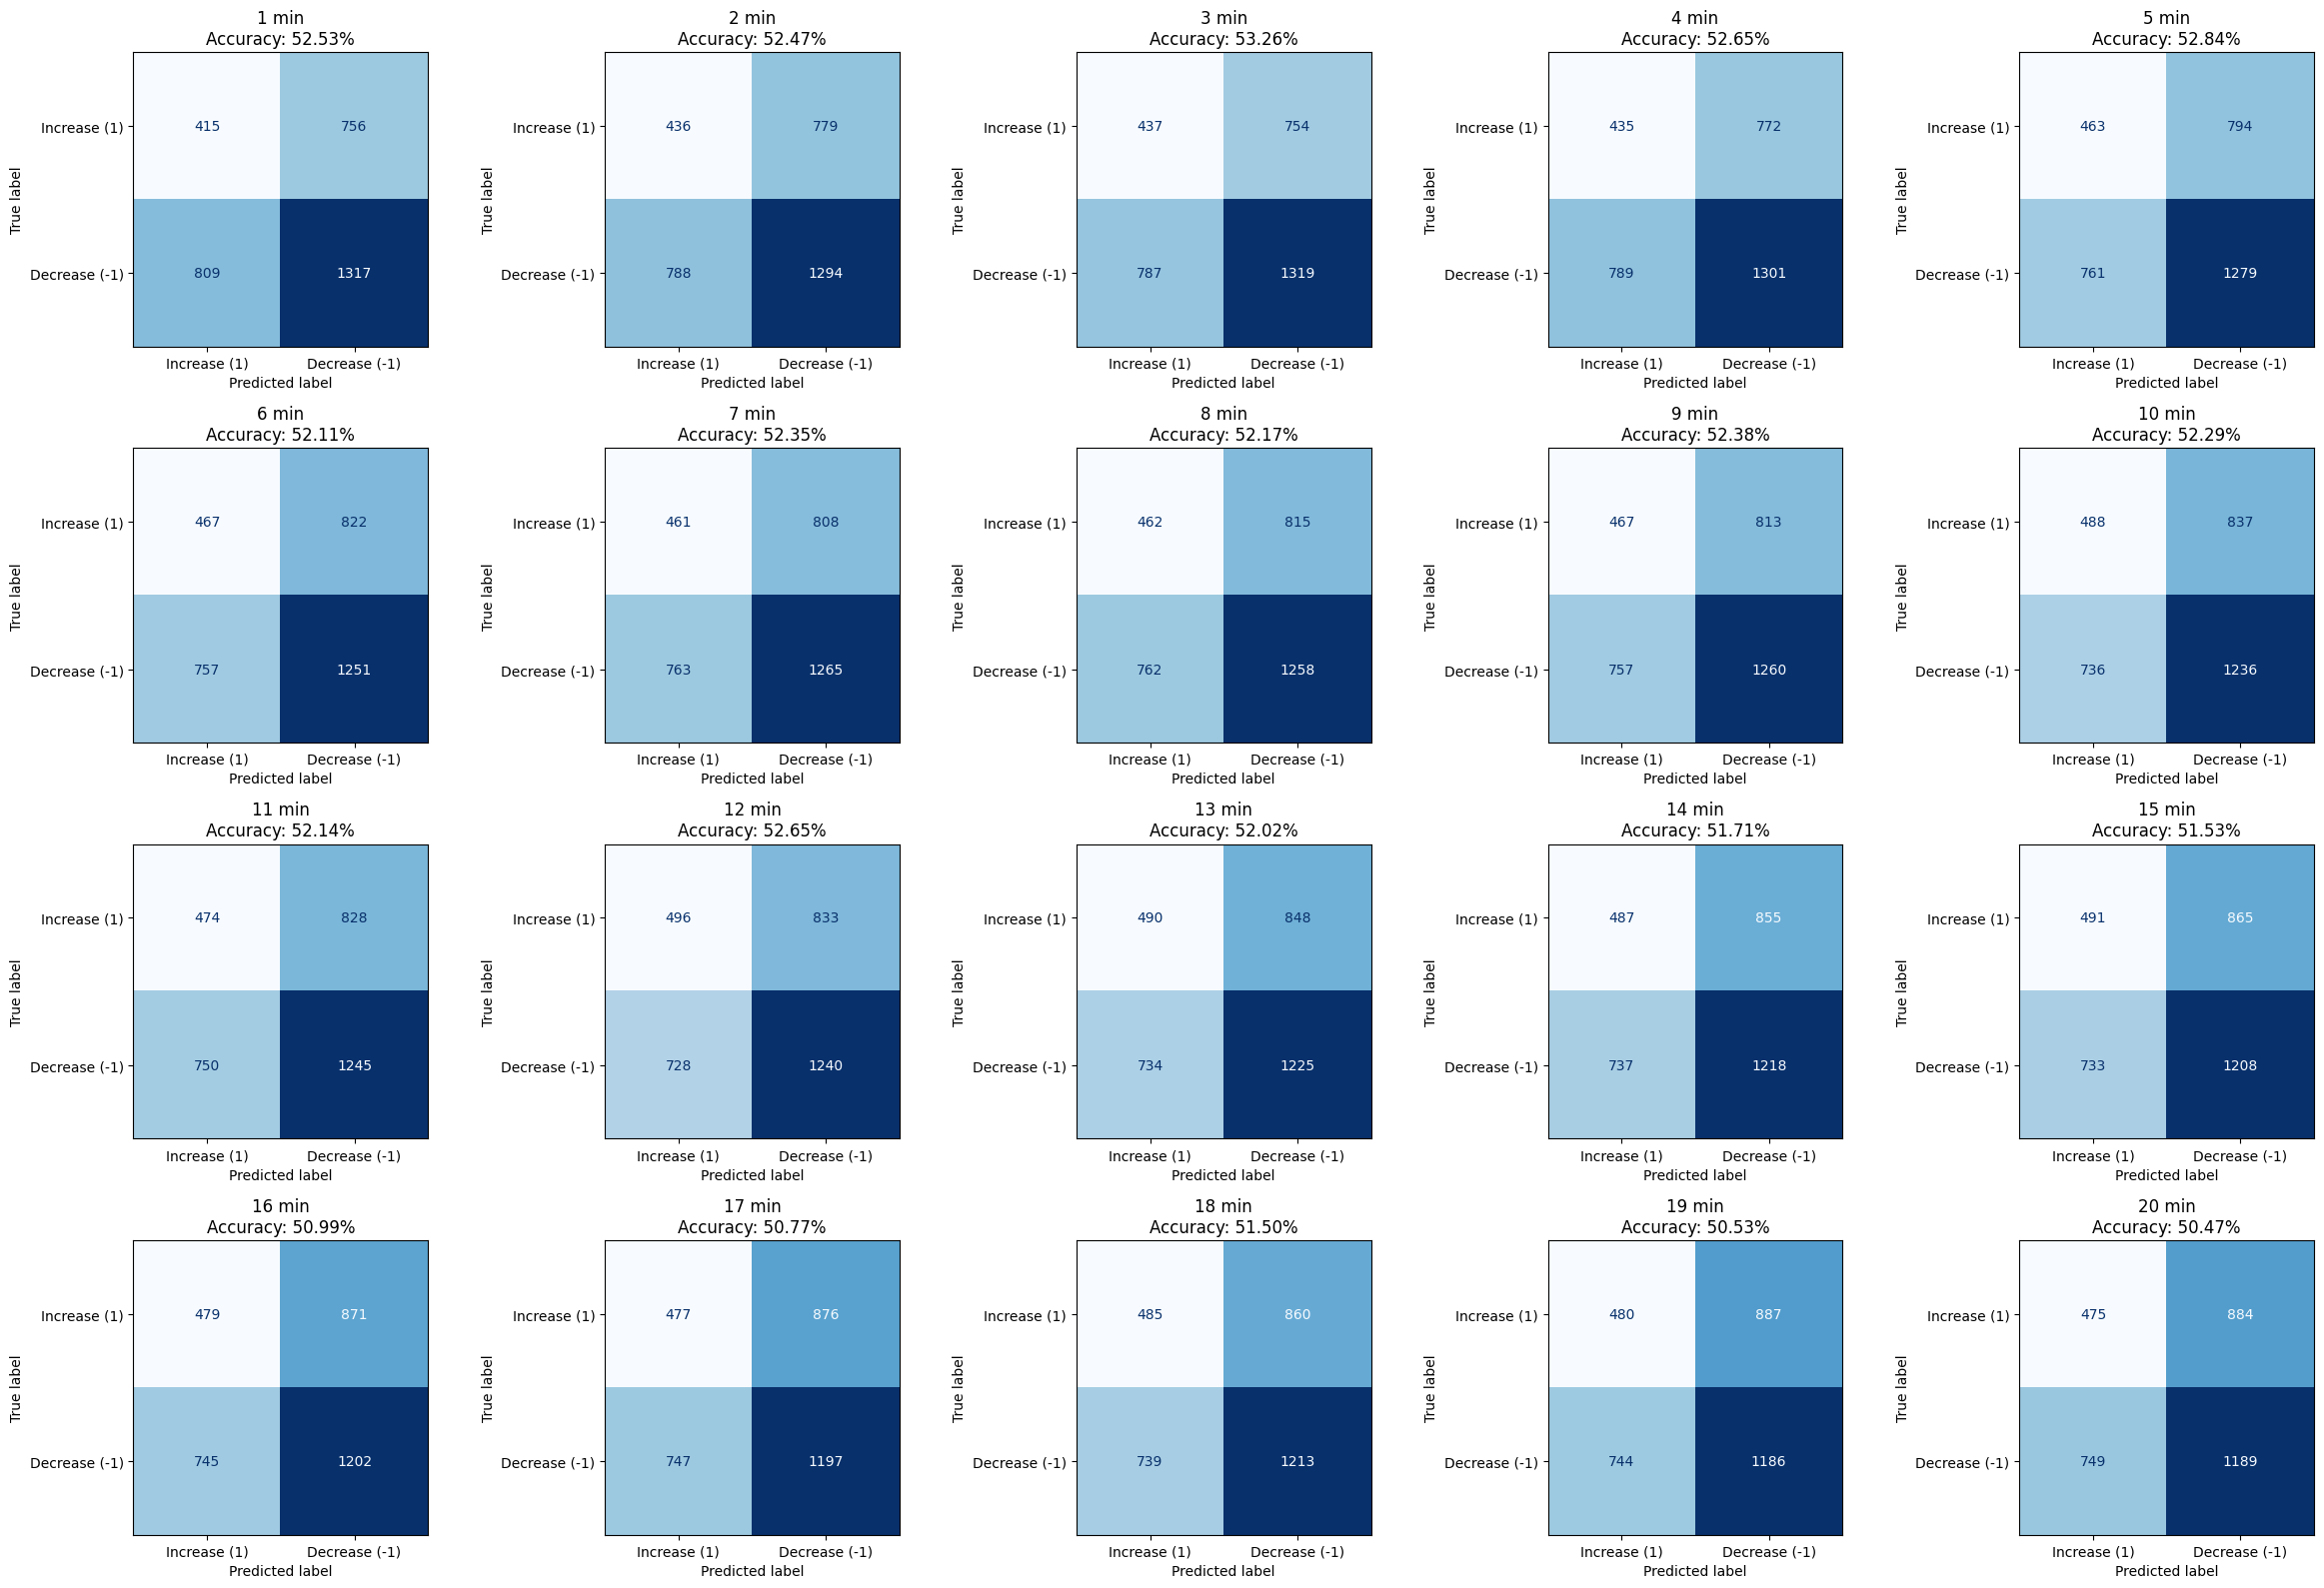

In [5]:
# Step 6: Evaluate predictions vs ground truth for t+1 to t+20 minutes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Drop rows where sentiment_pred is None (i.e., neutral or missing)
eval_df = allen_df.dropna(subset=['sentiment_pred'])

horizons = [(f'direction_gt_{i}', f'{i} min') for i in range(1, 21)]

fig, axes = plt.subplots(4, 5, figsize=(24, 16))
accuracies = []
for idx, (col, label) in enumerate(horizons):
    row, col_idx = divmod(idx, 5)
    y_true = eval_df[col] if col in eval_df else None
    y_pred = eval_df['sentiment_pred']
    if y_true is not None:
        cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Increase (1)', 'Decrease (-1)'])
        disp.plot(ax=axes[row, col_idx], cmap='Blues', colorbar=False)
        axes[row, col_idx].set_title(f'{label}\nAccuracy: {acc:.2%}')
    else:
        axes[row, col_idx].set_visible(False)
plt.tight_layout()

# Print accuracy for each horizon
for i, acc in enumerate(accuracies, 1):
    print(f'Accuracy for {i} min: {acc:.2%}')